In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
alpha = 2.5         # sensitivity factor to occupancy (tune as needed)
base_price = 10.0

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("dataset.csv")

Saving dataset.csv to dataset.csv


In [ ]:
df['price'] = base_price

In [ ]:
new_prices = []

In [ ]:
for lot_id, group in df.groupby('ID'):
    price = base_price
    prices = []
    for _, row in group.iterrows():
        occ = row['Occupancy']
        cap = row['Capacity']
        utilization = occ / cap if cap > 0 else 0
        price = price + alpha * utilization
        price = max(5, min(30, price))  # bound the price between $5 and $30
        prices.append(price)
    new_prices.extend(prices)


In [ ]:
df['Model1_Price'] = new_prices

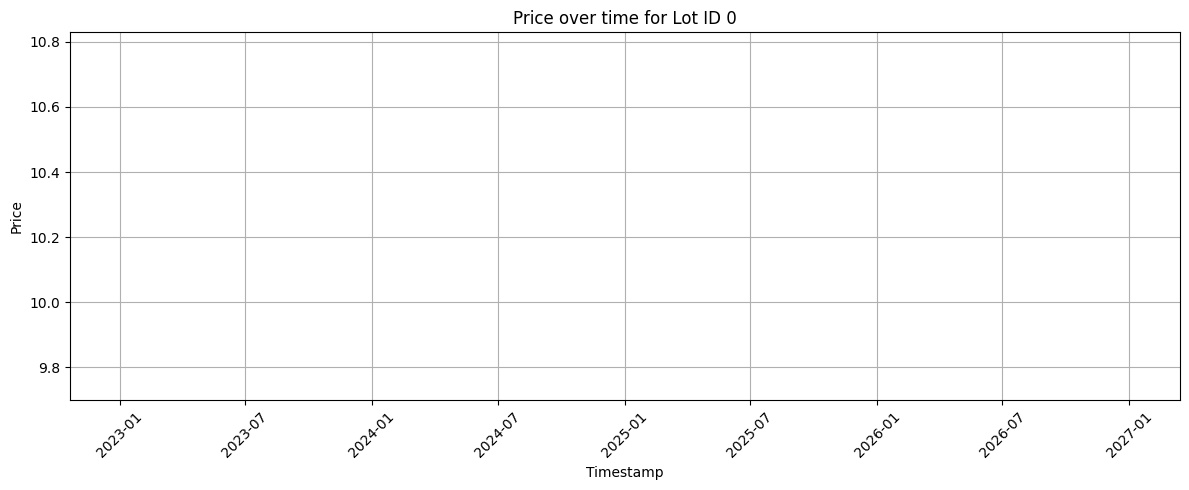

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 5))
sample_lot = df[df['ID'] == df['ID'].unique()[0]]
sns.lineplot(x=sample_lot['timestamp'], y=sample_lot['Model1_Price'])
plt.title(f"Price over time for Lot ID {sample_lot['ID'].iloc[0]}")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Convert relevant columns to numeric (if not already)
cols_to_convert = ['Occupancy', 'Capacity', 'QueueLength', 'TrafficConditionNearby', 'IsSpecialDay']
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Convert 'VehicleType' to numerical weights (if needed)
vehicle_type_map = {'car': 1.0, 'bike': 0.7, 'truck': 1.3}
df['VehicleTypeWeight'] = df['VehicleType'].map(vehicle_type_map).fillna(1.0)


In [21]:
df = df.sort_values(by=['ID', 'timestamp'])

In [22]:
vehicle_weights = {'car': 1.0, 'bike': 0.7, 'truck': 1.5}
df['VehicleTypeWeight'] = df['VehicleType'].map(vehicle_weights)

In [23]:
df['VehicleTypeWeight'] = df['VehicleTypeWeight'].fillna(1.0)

In [24]:
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']
df['TrafficNormalized'] = df['TrafficConditionNearby'] / df['TrafficConditionNearby'].max()
df['QueueNormalized'] = df['QueueLength'] / df['QueueLength'].max()

In [25]:
alpha = 1.5
beta = 0.8
gamma = 0.5
delta = 0.9
epsilon = 1.2
lambda_factor = 0.6
base_price = 10

In [26]:
df['RawDemand'] = (
    alpha * df['OccupancyRate'] +
    beta * df['QueueNormalized'] -
    gamma * df['TrafficNormalized'] +
    delta * df['IsSpecialDay'] +
    epsilon * df['VehicleTypeWeight']
)

In [27]:
df['NormalizedDemand'] = (df['RawDemand'] - df['RawDemand'].min()) / (df['RawDemand'].max() - df['RawDemand'].min())

In [28]:
df['Model2_Price'] = base_price * (1 + lambda_factor * df['NormalizedDemand'])
df['Model2_Price'] = df['Model2_Price'].clip(lower=5, upper=20)

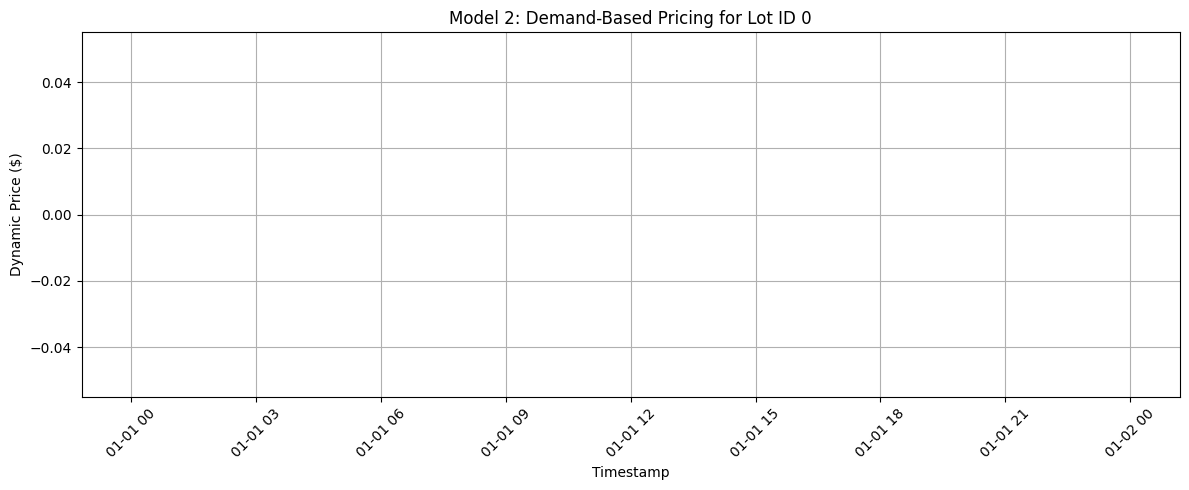

In [29]:
import seaborn as sns
plt.figure(figsize=(12, 5))
sample_lot = df[df['ID'] == df['ID'].unique()[0]]
sns.lineplot(x=sample_lot['timestamp'], y=sample_lot['Model2_Price'])
plt.title(f"Model 2: Demand-Based Pricing for Lot ID {sample_lot['ID'].iloc[0]}")
plt.xlabel("Timestamp")
plt.ylabel("Dynamic Price ($)")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()